In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [25]:
df = pd.read_csv('Effectifs_pooled.csv')
df.head()

,datetime,Réel,Prévision,joursem,isoweek
0,2011-01-03,11127.0,11905.0,0,1
1,2011-01-04,11800.0,12172.0,1,1
2,2011-01-06,11723.0,12363.0,3,1
3,2011-01-07,12320.0,12423.0,4,1
4,2011-01-10,11281.0,11932.0,0,2


In [26]:
df['datetime']=pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   1431 non-null   datetime64[ns]
 1   Réel       1431 non-null   float64       
 2   Prévision  1431 non-null   float64       
 3   joursem    1431 non-null   int64         
 4   isoweek    1431 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 56.0 KB


In [27]:
df['Mois']= df['datetime'].apply( lambda dt1 : dt1.month)
df['An']= df['datetime'].apply( lambda dt1 : dt1.year)
df.head()

,datetime,Réel,Prévision,joursem,isoweek,Mois,An
0,2011-01-03,11127.0,11905.0,0,1,1,2011
1,2011-01-04,11800.0,12172.0,1,1,1,2011
2,2011-01-06,11723.0,12363.0,3,1,1,2011
3,2011-01-07,12320.0,12423.0,4,1,1,2011
4,2011-01-10,11281.0,11932.0,0,2,1,2011


In [28]:
df_calend=pd.read_csv('calendrier_saisons_vacances.csv')
df_calend['datetime']=pd.to_datetime(df_calend['datetime'])
df_calend.drop(columns='Unnamed: 0',inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac
0,2011-01-03,1,False,1,54
1,2011-01-04,1,False,2,53
2,2011-01-06,1,False,4,51
3,2011-01-07,1,False,5,50
4,2011-01-10,1,False,8,47


In [29]:
df_calend1=pd.read_csv('calendrier_fetes_juives.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1=df_calend1[['datetime', 'Fete Juive']]
df_calend1.head()

,datetime,Fete Juive
0,2011-03-21,Pourim
1,2011-04-20,Pessah
2,2011-06-09,Chavouot
3,2011-08-10,Jeûne
4,2011-09-30,Roch


In [30]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['Fete Juive'].fillna('-', inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive
0,2011-01-03,1,False,1,54,-
1,2011-01-04,1,False,2,53,-
2,2011-01-06,1,False,4,51,-
3,2011-01-07,1,False,5,50,-
4,2011-01-10,1,False,8,47,-


In [31]:
df_calend1=pd.read_csv('calendrier_ramadan.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1.drop(columns='Unnamed: 0',inplace=True)
df_calend1.head()

,ramadan,datetime
0,1,2021-04-13
1,1,2021-04-14
2,1,2021-04-15
3,1,2021-04-16
4,1,2021-04-17


In [32]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['ramadan'].fillna(0, inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan
0,2011-01-03,1,False,1,54,-,0.0
1,2011-01-04,1,False,2,53,-,0.0
2,2011-01-06,1,False,4,51,-,0.0
3,2011-01-07,1,False,5,50,-,0.0
4,2011-01-10,1,False,8,47,-,0.0


Maintenant, un peu de feature engineering :

In [33]:
df_calend['DepVac_J']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend['DepVac_S']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1%7 )
df_calend['AvVac_J']=df_calend['durée_AvantVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,1,False,8,47,-,0.0,4,1,4


In [34]:
df= pd.merge(df,df_calend, how='left', on='datetime')
df.head()

,datetime,Réel,Prévision,joursem,isoweek,Mois,An,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,11127.0,11905.0,0,1,1,2011,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,11800.0,12172.0,1,1,1,2011,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,11723.0,12363.0,3,1,1,2011,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,12320.0,12423.0,4,1,1,2011,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,11281.0,11932.0,0,2,1,2011,1,False,8,47,-,0.0,4,1,4


In [35]:
df['AnMois']=df['datetime'].apply(lambda dt1 : str(dt1)[:7])
df.head()

,datetime,Réel,Prévision,joursem,isoweek,Mois,An,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J,AnMois
0,2011-01-03,11127.0,11905.0,0,1,1,2011,1,False,1,54,-,0.0,1,1,4,2011-01
1,2011-01-04,11800.0,12172.0,1,1,1,2011,1,False,2,53,-,0.0,2,2,4,2011-01
2,2011-01-06,11723.0,12363.0,3,1,1,2011,1,False,4,51,-,0.0,4,4,4,2011-01
3,2011-01-07,12320.0,12423.0,4,1,1,2011,1,False,5,50,-,0.0,4,5,4,2011-01
4,2011-01-10,11281.0,11932.0,0,2,1,2011,1,False,8,47,-,0.0,4,1,4,2011-01


In [36]:
df_mois_pool = df[['AnMois','Réel']].groupby('AnMois').median()
df_mois_pool.rename(columns={'Réel':'M0_Med'},inplace=True)
df_mois_pool['M-2_Med']=df_mois_pool['M0_Med'].shift(2)
df_mois_pool['M-2_Med'].fillna(11883.0, inplace=True)
df_mois_pool.head()

,M0_Med,M-2_Med
AnMois,,
2011-01,11883.0,11883.0
2011-02,11930.0,11883.0
2011-03,12231.0,11883.0
2011-04,12220.0,11930.0
2011-05,12152.0,12231.0


In [37]:
df=pd.merge(df,df_mois_pool,how='left',on="AnMois")
df.head()

,datetime,Réel,Prévision,joursem,isoweek,Mois,An,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J,AnMois,M0_Med,M-2_Med
0,2011-01-03,11127.0,11905.0,0,1,1,2011,1,False,1,54,-,0.0,1,1,4,2011-01,11883.0,11883.0
1,2011-01-04,11800.0,12172.0,1,1,1,2011,1,False,2,53,-,0.0,2,2,4,2011-01,11883.0,11883.0
2,2011-01-06,11723.0,12363.0,3,1,1,2011,1,False,4,51,-,0.0,4,4,4,2011-01,11883.0,11883.0
3,2011-01-07,12320.0,12423.0,4,1,1,2011,1,False,5,50,-,0.0,4,5,4,2011-01,11883.0,11883.0
4,2011-01-10,11281.0,11932.0,0,2,1,2011,1,False,8,47,-,0.0,4,1,4,2011-01,11883.0,11883.0


In [38]:
enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']])
enc.fit(df[['An','Mois','joursem']])
enc.categories_

[array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12], dtype=int64),
 array([0, 1, 2, 3, 4], dtype=int64)]

In [39]:
# X = enc.transform(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']]).toarray()
X1 = enc.transform(df[['An','Mois','joursem']]).toarray()
X2 = df[['M-2_Med', 'DepVac_J', 'DepVac_S', 'AvVac_J']].to_numpy()
X = np.concatenate((X1,X2),axis=1, out=None)
y = df['Réel']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model_fit = model.fit(X_train, y_train)

In [42]:
model_fit.coef_

array([-1.98300087e+03, -1.61100258e+03, -1.16193804e+03, -9.02772080e+02,
       -6.05075849e+02,  2.46580424e+02,  1.19860508e+03,  1.30193356e+03,
        9.67816912e+02,  1.33122579e+03,  1.07328825e+03,  1.44339414e+02,
       -9.77513851e+01,  1.22250392e+01,  1.27964368e+02,  1.71140024e+02,
        3.17844670e+02, -4.04171483e+02, -1.86270042e+03,  2.87307891e+02,
        5.90519463e+02,  5.66780608e+02,  2.90841222e+02,  8.84936188e+01,
        2.99632410e+02, -1.53728813e+03,  2.71067298e+02,  8.78094802e+02,
       -5.54032064e-02,  6.35973347e+01, -4.34718653e+00,  5.67338184e+01])

In [43]:
model_fit.intercept_

13692.119786523734

In [44]:
y_train_pred = model_fit.predict(X_train)
y_test_pred = model_fit.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [46]:
df_metric = pd.DataFrame( {'MSE': [mean_squared_error(y_train,y_train_pred), mean_squared_error(y_test,y_test_pred),mean_squared_error(df['Réel'],df['Prévision'])],
                           'RMSE': [sqrt(mean_squared_error(y_train,y_train_pred)), sqrt(mean_squared_error(y_test,y_test_pred)),sqrt(mean_squared_error(df['Réel'],df['Prévision']))],
                           'r2': [r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred), r2_score(df['Réel'],df['Prévision'])]}, index=['Train','Test','Prévision'] )

df_metric.head()

,MSE,RMSE,r2
Train,815966.877086,903.308849,0.662567
Test,962968.081130,981.309371,0.616604
Prévision,845185.453529,919.339683,0.653455


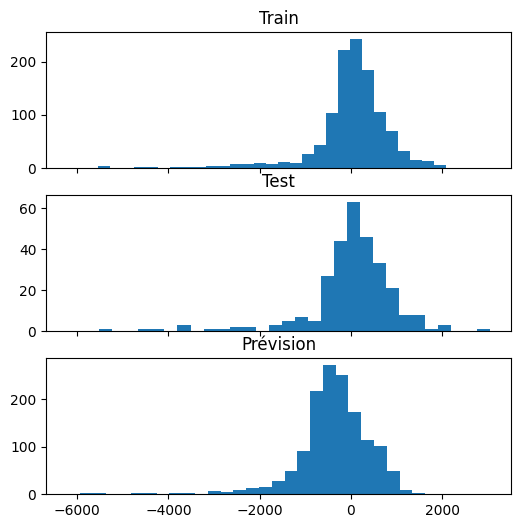

In [47]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax1.set_title('Train')
ax1.hist(y_train-y_train_pred, bins = 30)
ax2.set_title('Test')
ax2.hist(y_test-y_test_pred, bins = 30)
ax3.set_title('Prévision')
ax3.hist(df['Réel']-df['Prévision'], bins = 30)
plt.show()

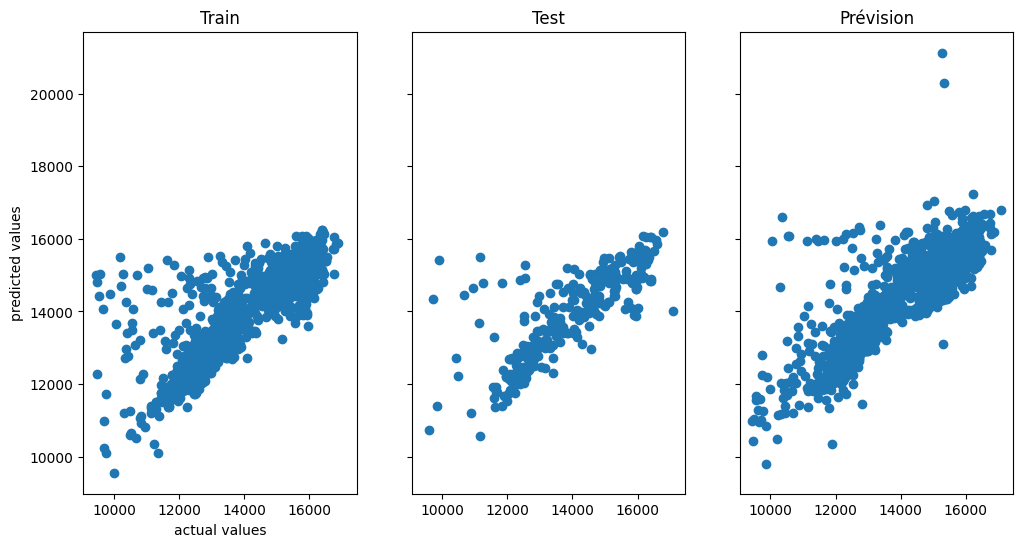

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6), sharex=True, sharey=True)
ax1.set_title('Train')
ax1.set_xlabel('actual values')
ax1.set_ylabel('predicted values')
ax1.scatter(x=y_train, y=y_train_pred)
ax2.set_title('Test')
ax2.scatter(x=y_test, y=y_test_pred)
ax3.set_title('Prévision')
ax3.scatter(x=df['Réel'], y=df['Prévision'])
plt.show()